In [30]:
options(warn=-1)

library(tseriesChaos)
library(deSolve)
library(pracma)

## Transient Logistic Map

In this example, we produce the transient logistic map, in which the logistic map $x_{t+1} = r \cdot x_t (1 - x_t)$ is iterated while the parameter of $r$ is changed on each iteration.

In [2]:
logistic_map <- function(t, input, parms) {
    x <- input[1]
    r <- parms[1]
    dx <- r * x * (1 - x)
    
    list(c(dx))
}

In [3]:
transient_map_iterator <- function(syst, start.time, end.time, dt,
                                   initial.condition, parms=NULL, parms.mod=NULL, runge.kutta=F) {
    times <- seq(start.time, end.time, by=dt)
    x <- initial.condition
    
    ret <- NULL
    for (t in times) {
        ret <- rbind(ret, x)
        x <- syst(t, x, parms)[[1]] * dt
        parms <- parms + parms.mod
    }
    
    ret
}

In [4]:
transient_logistic_map <- function(N, initial.condition=c(0.6),
                                   parms.initial=c(2.8), parms.end=c(4.0), dt=1) {
    parms.mod <- (parms.end - parms.initial)/N
    
    transient_map_iterator(logistic_map, start.time=1, end.time=N, dt=1, initial.condition,
                           parms.initial, parms.mod, runge.kutta=F)
}

## Multidimensional Fourier Transform (MDFT) Algorithm

Here we define the functions for the MDFT algorithm.

In [5]:
mdft_quantize <- function(embedded.data, nbins) {
    discretized.data <- embedded.data
    
    for (i in 1:ncol(embedded.data)) {
        min.data <- min(embedded.data[,i], na.rm=T)
        max.data <- max(embedded.data[,i], na.rm=T)
        
        discretized.data[,i] <- findInterval(embedded.data[,i], seq(from=min.data,
                                                                    to=max.data,
                                                                    by=((max.data - min.data)/(nbins - i))))
    }
    
    grid <- list()
    
    for (i in 1:nrow(discretized.data)) {
        key <- strcat(as.character(discretized.data[i,]), collapse="#")
        
        if (is.null(grid[[key]])) {
            grid[[key]] <- 1
        } else {
            grid[[key]] <- grid[[key]] + 1
        }
    }
    
    return(grid)
}

In [6]:
mdft_assimilate_to_grid <- function(grid, key) {
    key <- strcat(as.character(key), collapse="#")
    if (is.null(grid[[key]])) {
        return(0)
    } else {
        return(grid[[key]])
    }
}

In [7]:
mdft <- function(grid, coordinates) {
    aux.grid <- grid
    
    for (i in 1:ncol(coordinates)) {
        for (dim in min(coordinates[,i]):max(coordinates[,i])) {
            indexes <- which(coordinates[,i] == dim)
            series <- c()
            
            for (index in indexes) {
                key <- strcat(as.character(coordinates[index,]), collapse="#")
                qtt <- mdft_assimilate_to_grid(aux.grid, key)
                series <- c(series, qtt)
            }
            
            ret <- fft(series)
            
            for (j in 1:length(indexes)) {
                key <- strcat(as.character(coordinates[indexes[j],]), collapse="#")
                if (is.null(aux.grid[[key]])) {
                    aux.grid[[key]] <- ret[j]
                } else {
                    aux.grid[[key]] <- aux.grid[[key]] + ret[j]
                }
            }
        }
    }
    
    return(aux.grid)
}

In [8]:
mdft_process <- function(data, m, d, nbins) {
    coordinates <- expand.grid(replicate(m, 1:nbins, simplify=F))
    
    embedded.data <- embedd(data, m, d)
    
    grid <- mdft_quantize(embedded.data, nbins)
    coefs <- mdft(grid, coordinates)
    
    as.complex(coefs)
}

In [9]:
mdft_compare_models <- function(A, B) {
    mag_A <- NULL
    mag_B <- NULL
    
    for (i in 1:length(B)) {
        mag_A <- cbind(mag_A, sqrt(Re(A[[i]])^2 + Im(A[[i]])^2))
        mag_B <- cbind(mag_B, sqrt(Re(B[[i]])^2 + Im(B[[i]])^2))
    }
    
    eig_A <- svd(mag_A)$d
    eig_B <- svd(mag_B)$d
    diff <- 0
    value <- 0
    prob <- c()
    for (ev in 1:length(eig_A)) {
        prob <- c(prob, abs(eig_A[ev] - eig_B[ev]) / max(c(eig_A[ev], eig_B[ev])))
    }
    
    ret <- -sum(prob[prob > 0] * log2(prob[prob > 0]))
    
    return(ret)
}

## Executing a test

In [10]:
# Producing the data stream

N <- 1.2e+5

ds <- transient_logistic_map(N)

In [21]:
# Setting up the MDFT algorithm

# window parameters
window.length <- 800
window.step <- 10
window.index <- 1

# embedding parameters
m <- 2
d <- 1

# MDFT parameters
nbins <- 13

# stateful variables
A <- NULL
B <- NULL
mdft_dif <- c()

In [22]:
# Sliding window and comparing consecutive models

for (i in 1:length(seq(window.length, N, by=window.step))) {
    
    # slide window
    window <- ds[window.index:(window.length + window.index - 1)]
    window.index <- window.index + window.step
    
    # produce a model (based on MDFT)
    model <- mdft_process(window, m=m, d=d, nbins=nbins)
    
    if (!is.null(A)) {
        B <- A
    }

    A <- model

    # compare consecutive models
    if (!is.null(B)) {
        dif <- mdft_compare_models(A, B)
        mdft_dif <- c(mdft_dif, dif)
    }
}

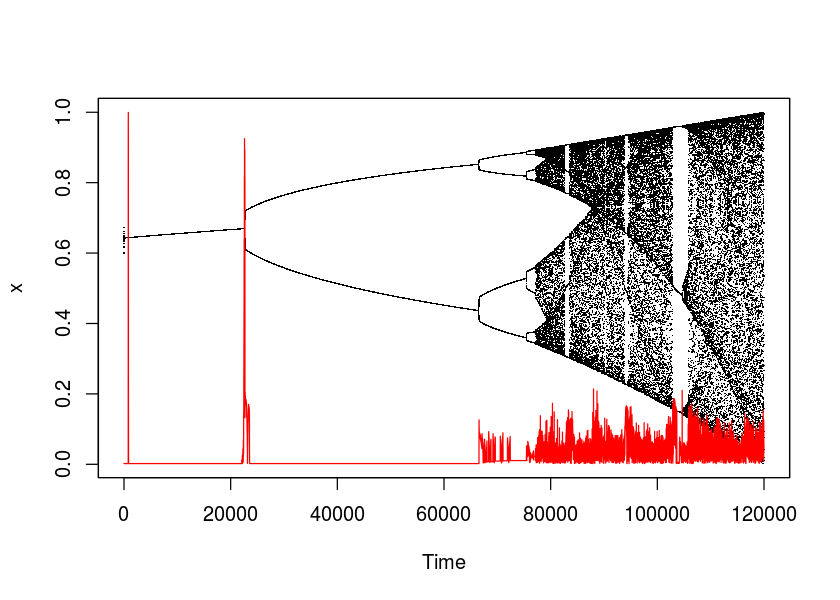

In [38]:
# Plotting the datastream and the MDFT comparison between consecutive models

options(repr.plot.width=7, repr.plot.height=5)

mdft_plot_dif <- c(rep(0, trunc(window.length / window.step)), mdft_dif)

plot(ds, pch='.', xlab='Time', ylab='x')
par(new=T, ann=F, xaxt='n', yaxt='n')
ts.plot(mdft_plot_dif, col=2)